In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import keras
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn import metrics
from keras import models
from keras import layers
from keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from sklearn.preprocessing import LabelEncoder

In [68]:
# Data gathering

x = []
y = []
IM_SIZE = 200
NUM_CLASSES = 120
path = './Data/dog-breed-identification'

df = pd.read_csv(f'{path}/labels.csv', header=0)
breeds = list(df.breed.value_counts()[:NUM_CLASSES].index)
labels = df[df.breed.isin(breeds)]

for root, _, files in os.walk(f'{path}/train/'):
    for file in files:
        if file.split(".")[0] in labels.id.values:
            img = load_img(f'{root}/{file}', grayscale=False, color_mode='rgb', target_size=(IM_SIZE, IM_SIZE))
            x.append(img_to_array(img))
            y.append(labels[labels.id == file.split(".")[0]].breed)

x = np.array(x)

In [69]:
# Label Encoding
le = LabelEncoder() 
y = le.fit_transform(y)

In [71]:
mapping = dict(zip(range(len(le.classes_)), le.classes_))

In [72]:
# Data splitting

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25)

In [73]:
y_train = keras.utils.to_categorical(y_train, num_classes=NUM_CLASSES)
y_test = keras.utils.to_categorical(y_test, num_classes=NUM_CLASSES)

In [74]:
# Data generators

train_datagen = ImageDataGenerator(
    rotation_range=35,
    width_shift_range=0.25,
    height_shift_range=0.25,
    rescale=1./255,
    shear_range=0.25,
    zoom_range=0.25,
    horizontal_flip=True,
    fill_mode='nearest')

test_datagen=ImageDataGenerator(rescale=1./255)

training_set=train_datagen.flow(x_train,y=y_train,batch_size=64)
testing_set=test_datagen.flow(x_test,y=y_test,batch_size=64)

In [75]:
# Model
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization, Flatten, Dense, Dropout
from keras.models import Sequential

model = models.Sequential()

model.add(Conv2D(8,input_shape=(IM_SIZE,IM_SIZE, 3),kernel_size=(3,3),activation='relu'))
model.add(Dropout(0.25))
model.add(MaxPooling2D((2,2)))
model.add(BatchNormalization())
model.add(Conv2D(16,kernel_size=(3,3),activation='relu'))
model.add(MaxPooling2D((2,2)))
model.add(Dropout(0.4))
model.add(BatchNormalization())
model.add(Conv2D(32,kernel_size=(3,3),activation='relu'))
model.add(MaxPooling2D((2,2)))
model.add(Flatten())
model.add(Dense(240, activation='relu', kernel_regularizer=keras.regularizers.L2(0.0005)))
model.add(Dropout(0.2))
model.add(Dense(NUM_CLASSES, activation='softmax', kernel_regularizer=keras.regularizers.L2(0.00025)))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 198, 198, 8)       224       
_________________________________________________________________
dropout (Dropout)            (None, 198, 198, 8)       0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 99, 99, 8)         0         
_________________________________________________________________
batch_normalization (BatchNo (None, 99, 99, 8)         32        
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 97, 97, 16)        1168      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 48, 48, 16)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 48, 48, 16)        0

In [80]:
from keras import optimizers

model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-4),
              metrics=['acc'])

history = model.fit(training_set, validation_data=testing_set, epochs=200, callbacks=[keras.callbacks.EarlyStopping(monitor="val_loss", patience=3)])

Epoch 1/200
14/14 [==============================] - 14s 858ms/step - loss: 2.3006 - acc: 0.1224 - val_loss: 2.3066 - val_acc: 0.0804
Epoch 2/200
14/14 [==============================] - 14s 1s/step - loss: 2.3016 - acc: 0.1161 - val_loss: 2.3065 - val_acc: 0.0804
Epoch 3/200
14/14 [==============================] - 15s 1s/step - loss: 2.3017 - acc: 0.1089 - val_loss: 2.3065 - val_acc: 0.0804
Epoch 4/200
14/14 [==============================] - 13s 896ms/step - loss: 2.3021 - acc: 0.1255 - val_loss: 2.3064 - val_acc: 0.0804
Epoch 5/200
14/14 [==============================] - 13s 894ms/step - loss: 2.3022 - acc: 0.1165 - val_loss: 2.3064 - val_acc: 0.0804
Epoch 6/200
14/14 [==============================] - 13s 882ms/step - loss: 2.3013 - acc: 0.1236 - val_loss: 2.3064 - val_acc: 0.0804
Epoch 7/200
14/14 [==============================] - 13s 890ms/step - loss: 2.3019 - acc: 0.1116 - val_loss: 2.3063 - val_acc: 0.0804
Epoch 8/200
14/14 [==============================] - 13s 899ms/step 

Epoch 63/200
14/14 [==============================] - 15s 1s/step - loss: 2.3009 - acc: 0.1319 - val_loss: 2.3054 - val_acc: 0.0804


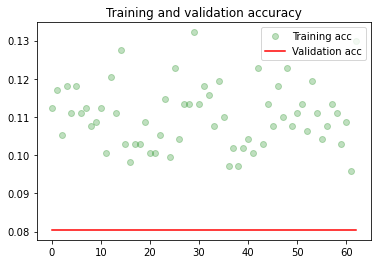

In [81]:
# Accuracy plot

plt.plot(history.history['acc'], 'go', label='Training acc', alpha=0.25)
plt.plot(history.history['val_acc'], 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.show()

In [ ]:
model.save("dbc.h5")